In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from statistics import mode
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/V_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]

,label,cycle number,Capacity/mA.h,Norm_Cap,Cycles Until Fail,20004.453 Re,15829.126 Re,12516.703 Re,9909.4424 Re,7835.48 Re,...,0.06443 Im,0.05102 Im,0.04042 Im,0.03192 Im,0.02528 Im,0.01999 Im,EIS_PCA_1,EIS_PCA_2,category,temperature
0,25C01,2,37.202713,1.0,234,0.38470,0.39156,0.39684,0.40341,0.40963,...,0.15473,0.18024,0.21535,0.25411,0.29026,0.32795,-0.648439,0.135808,1.0,25.0
261,25C02,2,35.060836,1.0,12,0.27315,0.28005,0.28916,0.29896,0.31009,...,0.16948,0.19432,0.23012,0.27316,0.31468,0.35528,0.997356,-0.606846,0.0,25.0
442,25C03,2,36.771703,1.0,164,0.26859,0.27977,0.28738,0.29862,0.31003,...,0.18334,0.21595,0.25083,0.28522,0.32480,0.37723,1.561054,-0.809891,0.0,25.0
644,25C04,2,35.534219,1.0,114,0.26546,0.27469,0.28046,0.29147,0.30112,...,0.18886,0.21123,0.24230,0.28393,0.32850,0.37336,1.061945,-0.751243,0.0,25.0
679,25C05,2,37.210831,1.0,152,0.34630,0.35399,0.35952,0.36615,0.37339,...,0.15592,0.17752,0.20654,0.23916,0.27151,0.31109,-1.097987,-0.006821,0.0,25.0
954,25C06,2,35.992184,1.0,120,0.29226,0.29988,0.30750,0.31758,0.32662,...,0.17112,0.19462,0.22959,0.27546,0.32275,0.36648,0.706666,-0.459589,0.0,25.0
1166,25C07,2,35.684646,1.0,32,0.30065,0.30717,0.31678,0.32634,0.33815,...,0.17637,0.20248,0.24127,0.28804,0.33312,0.37771,1.237057,-0.580435,0.0,25.0
1306,25C08,2,33.943672,1.0,32,0.28914,0.29589,0.30454,0.31619,0.32735,...,0.18095,0.20767,0.24267,0.28048,0.32001,0.37131,1.384369,-0.730253,0.0,25.0
1343,35C01,2,40.113305,1.0,218,0.27500,0.28167,0.28649,0.29203,0.29889,...,0.14148,0.15970,0.18417,0.21406,0.24424,0.27584,-2.642164,-0.091726,1.0,35.0
1670,35C02,2,40.473768,1.0,262,0.47084,0.47585,0.48147,0.48775,0.49372,...,0.13944,0.15736,0.18120,0.21156,0.24130,0.27295,-1.313667,0.634642,1.0,35.0


In [3]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

#Generate a dataframe with the first 40 cycles only
df_40 = df[(df['cycle number']<=40)]

In [4]:
def run_Classification_ML(df,Train_L,Test_L,feats,model):
    feature_names=feats
    train_df = pd.DataFrame(columns = df.columns)
    for Label in Train_L:
            selected_rows = df[df['label'] == Label]
            train_df = pd.concat([train_df,selected_rows],ignore_index=True) 
    X_train = train_df[feature_names]
    y_train = train_df['category']
    
    test_df = pd.DataFrame(columns = df.columns)
    for Label in Test_L:
        #Get the correct train test splits. 
        selected_rows = df[df['label'] == Label]
        test_df = pd.concat([test_df,selected_rows],ignore_index=True) 
    X_test = test_df[feature_names]
    y_test = test_df['category']
    #Running the Model
    clf = model
    clf.fit(X_train, y_train)
    clf_pred=clf.predict(X_test)   
    return y_test.to_list(),clf_pred,clf
        


[[1. 0.]
 [0. 1.]]


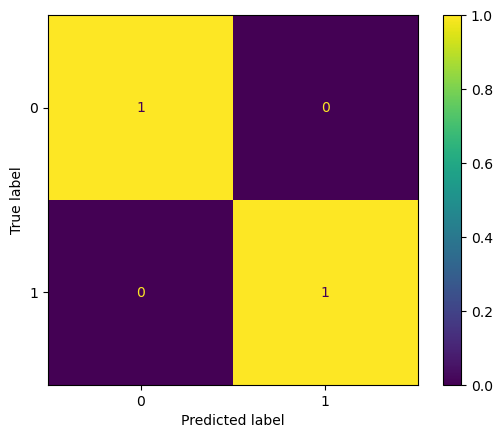

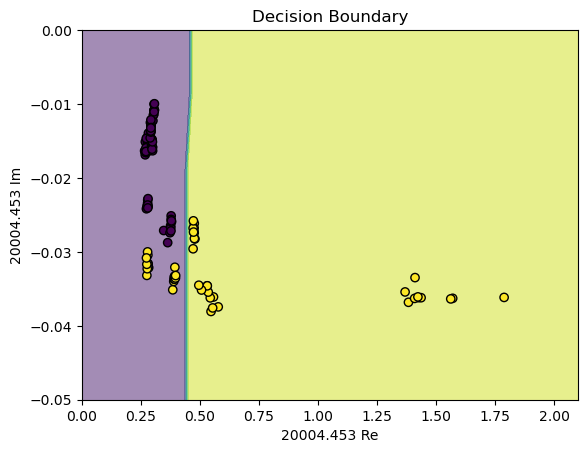

[[ 5.62395 -1.32345]]


In [6]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=200)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[0.75 0.25]
 [0.   1.  ]]


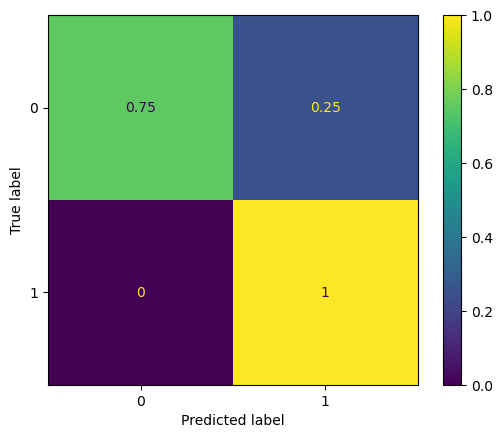

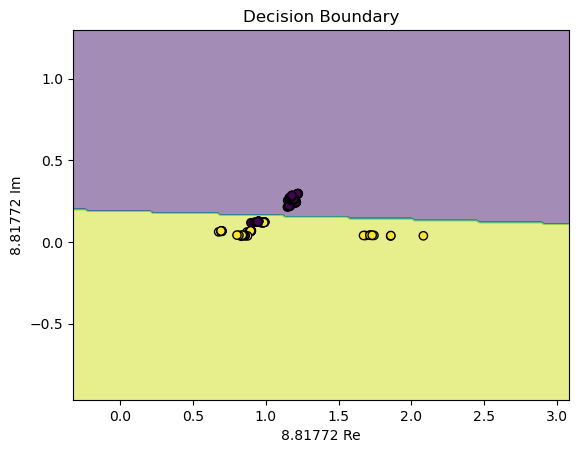

[[-0.24698232 -9.72053043]]


In [20]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['8.81772 Re','8.81772 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=200)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[0.75 0.25]
 [0.   1.  ]]


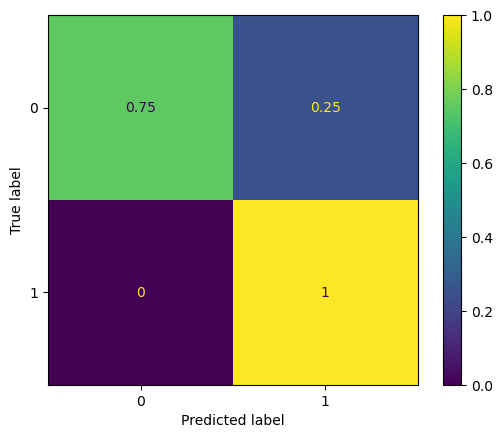

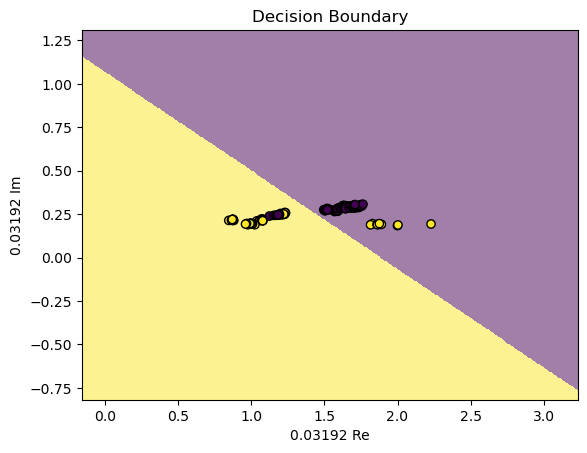

[[-3.38235 -5.9637 ]]


In [9]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['0.03192 Re','0.03192 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

#Normalize true normalizes over the true label count.
cm=confusion_matrix(tc,pc,normalize='true')
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

In [7]:
###
### First 40 cycles
###
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','8.81772 Im','temperature']
mydf=df_40

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

['20004.453 Im' '8.81772 Im' 'temperature']
[-524.16664556 -480.26010208    9.15610291]


For Batterty 25C05 The Predicted RuL at Cycle 10 is: 137.82625365641292
The True RuL at Cycle 10 is: 144


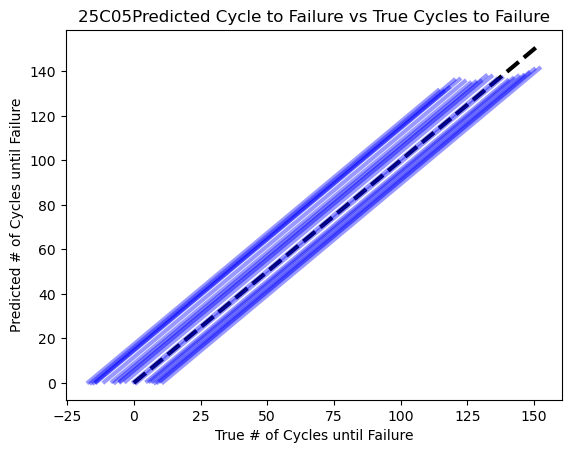

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 86.4398574433304
The True RuL at Cycle 10 is: 112


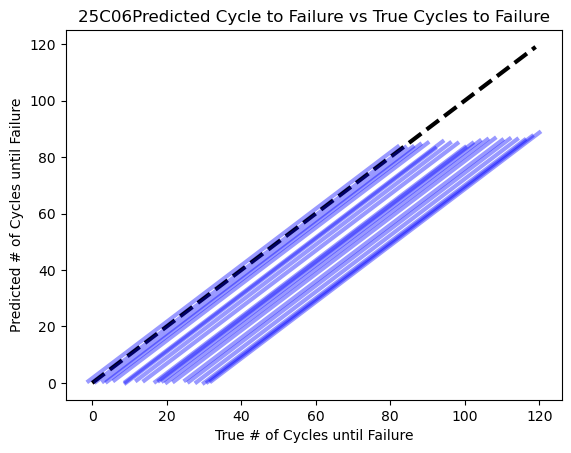

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 55.70903240125372
The True RuL at Cycle 10 is: 24


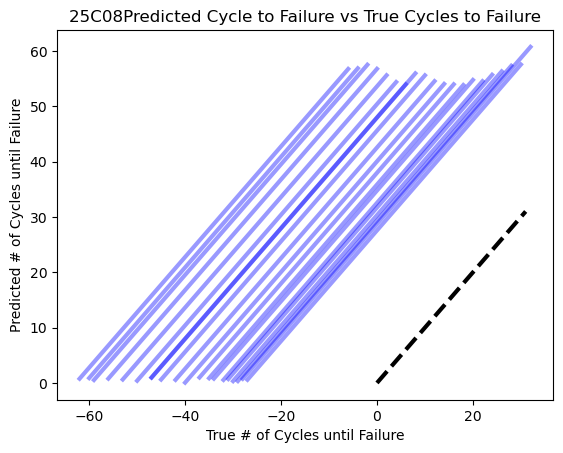

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 256.75760944399866
The True RuL at Cycle 10 is: 254


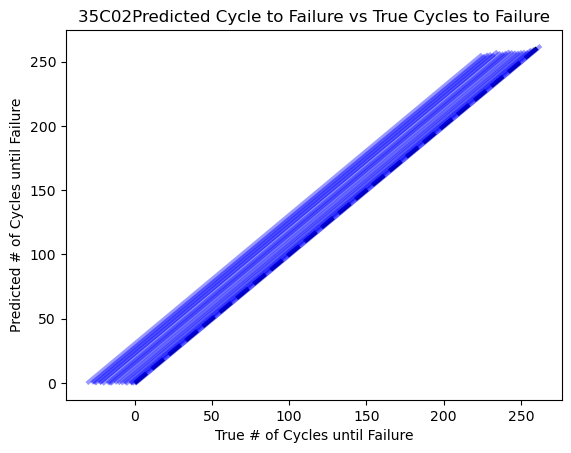

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 366.09336451934024
The True RuL at Cycle 10 is: 380


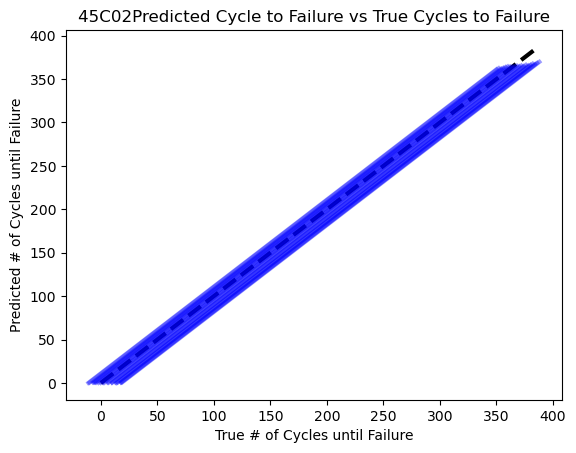

In [8]:
for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

In [9]:
###
### First 40 cycles
### Only 20kHz
###
Train_Lst=['25C01','25C02','25C03','25C07','35C01','45C01']
Test_Lst=['25C05','25C06','25C08','35C02','45C02']
feats1=['20004.453 Im','temperature']
mydf=df_40

model = Lasso(alpha=0.1,random_state=42)
Trained_Model=Train_Regr_ML(mydf,Train_Lst,model,feats1)
print(Trained_Model.feature_names_in_)
print(Trained_Model.coef_)

['20004.453 Im' 'temperature']
[-3437.94176496    12.09627513]


For Batterty 25C05 The Predicted RuL at Cycle 10 is: 103.74786572262195
The True RuL at Cycle 10 is: 144


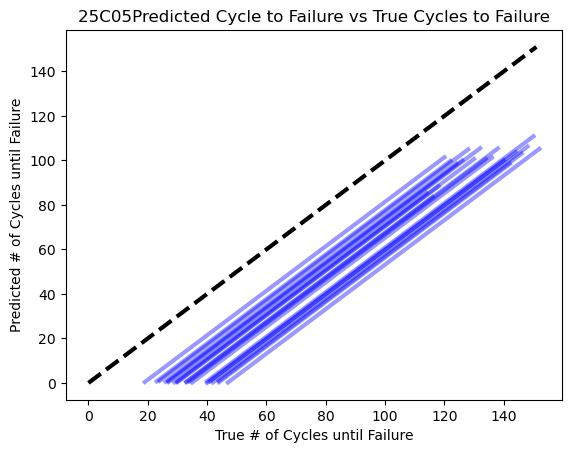

For Batterty 25C06 The Predicted RuL at Cycle 10 is: 62.87073813719985
The True RuL at Cycle 10 is: 112


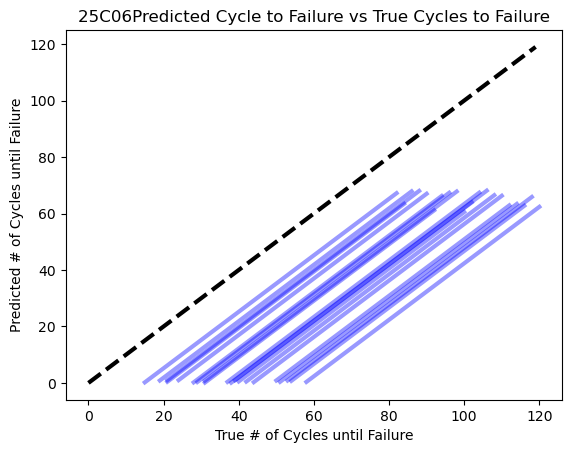

For Batterty 25C08 The Predicted RuL at Cycle 10 is: 58.81396685454229
The True RuL at Cycle 10 is: 24


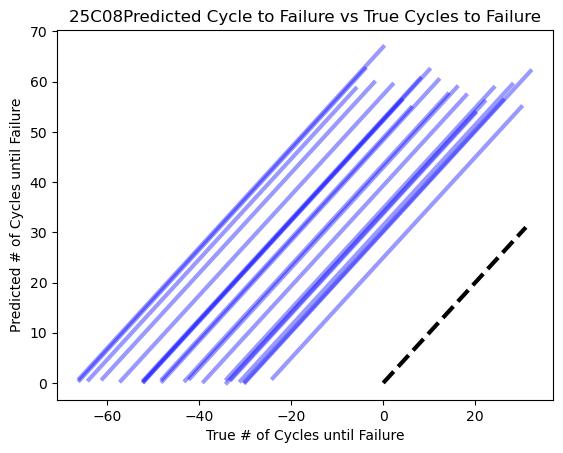

For Batterty 35C02 The Predicted RuL at Cycle 10 is: 222.85412844669736
The True RuL at Cycle 10 is: 254


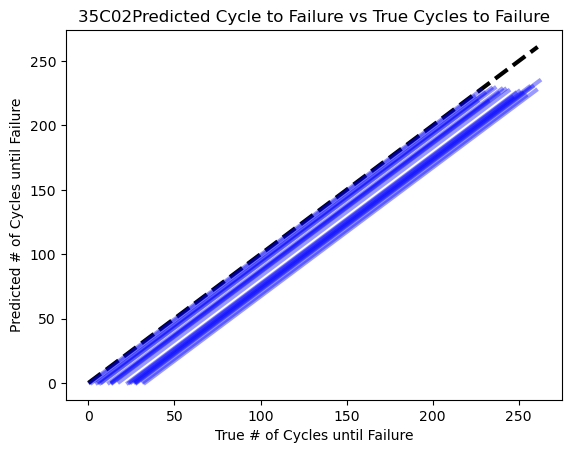

For Batterty 45C02 The Predicted RuL at Cycle 10 is: 378.4369532970409
The True RuL at Cycle 10 is: 380


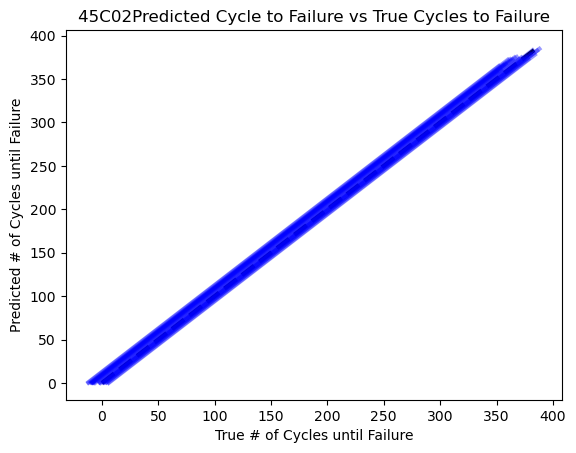

In [10]:
for Label in Test_Lst:
    Pred,TruC=Test_Regr_Model(mydf,Label,Trained_Model,feats1)
    print('For Batterty',Label,'The Predicted RuL at Cycle 10 is:',Pred[4])
    print('The True RuL at Cycle 10 is:',TruC[4])
    make_Cycling_Plots(Pred,TruC,Label)

[[68  2]
 [11 39]]
{'25C01': [1.0, array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '25C02': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C03': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C04': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C05': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])], '25C06': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C07': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '25C08': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '35C01': [0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])], '35C02': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '45C01': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])], '45C02': [1.0, array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]}


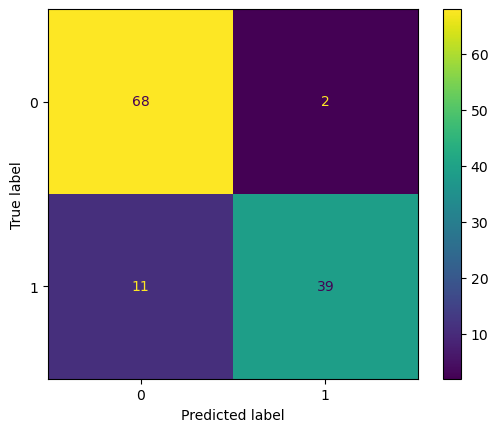

In [11]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=15, random_state=121)
true_c=[]
pred_c=[]
p_dict={}
train_Lst = ['25C01','25C02','25C03','25C04','25C05','25C06','25C07','25C08','35C01','35C02','45C01','45C02']
for bat1 in train_Lst:
    train_Lst = ['25C01','25C02','25C03','25C04','25C05','25C06','25C07','25C08','35C01','35C02','45C01','45C02']
    test_Lst = [bat1]
    for battery in test_Lst:
        train_Lst.remove(battery)
    tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)
    p_dict[bat1]=[mode(pc),pc]
    for x in tc:
        true_c.append(x)
    for y in pc:
        pred_c.append(y)

cm=confusion_matrix(true_c,pred_c)
print(cm)
print(p_dict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

[[40  0]
 [ 0 20]]


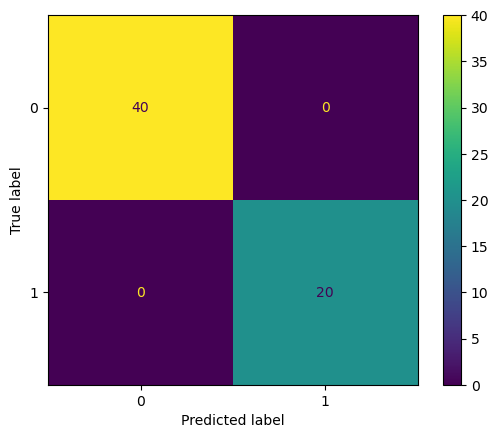

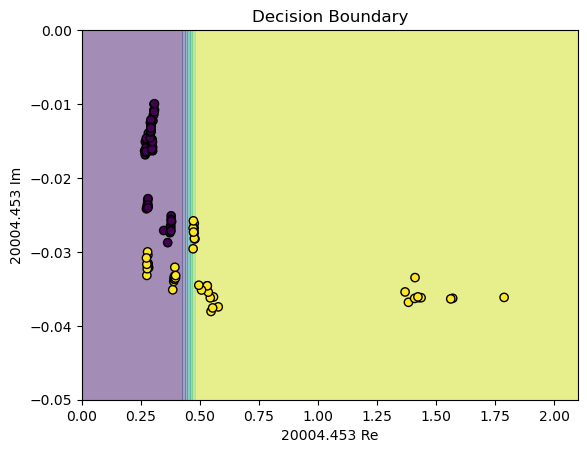

[[ 5.62395 -1.32345]]


In [12]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=5, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=50)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[69  1]
 [ 0 50]]


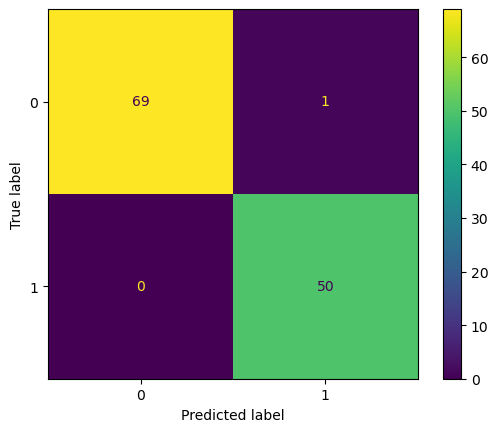

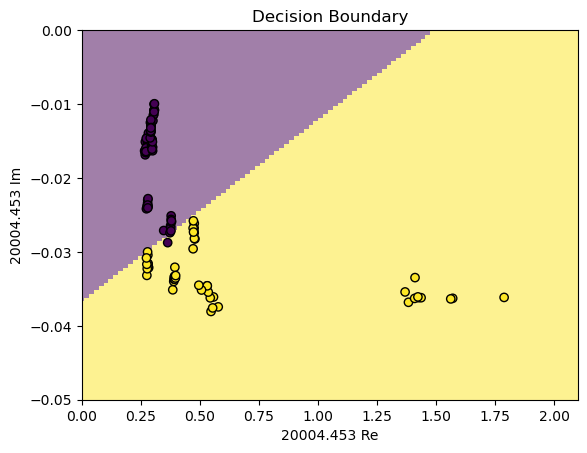

[[  13.82795596 -563.05197518]]
[-20.64287536]


In [21]:
my_feats=['20004.453 Re','20004.453 Im']

model=SVC(kernel="linear", C=40000, random_state=42)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
#print(X_Total)
#disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,grid_resolution=50)
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=4000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)
print(tmdl.intercept_)

In [2]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=DecisionTreeClassifier(criterion='gini',max_depth=5)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",alpha=0.3,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


NameError: name 'DecisionTreeClassifier' is not defined

[[36  4]
 [ 4 16]]


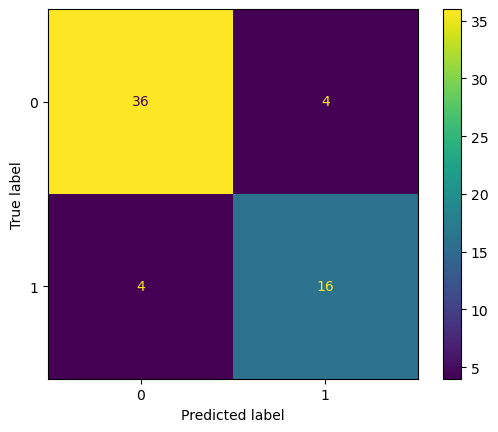

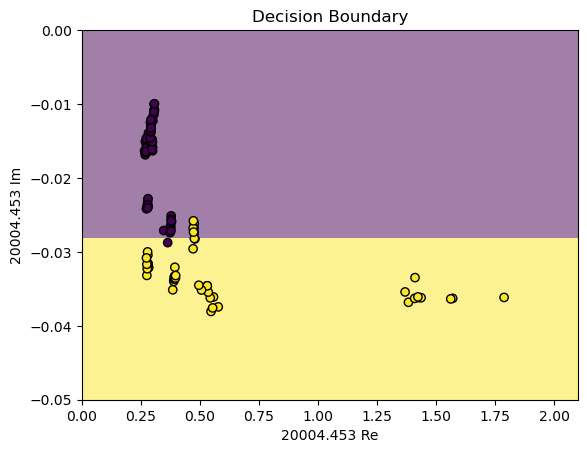

In [22]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=DecisionTreeClassifier(criterion='gini',max_depth=5)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[70  0]
 [ 0 50]]


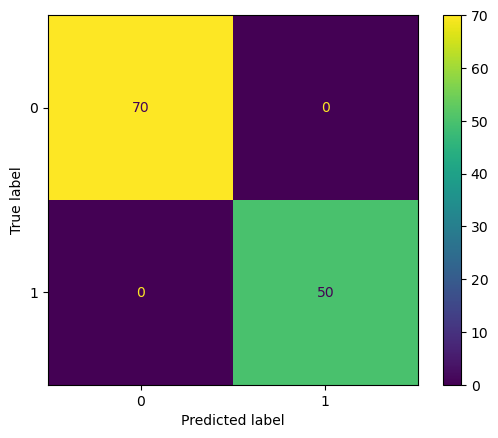

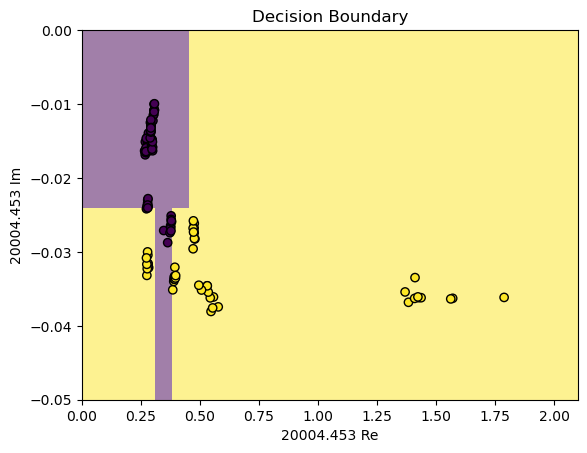

In [23]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=50)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[70  0]
 [ 0 50]]


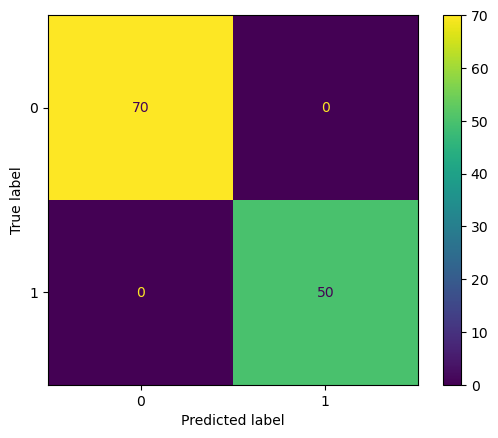

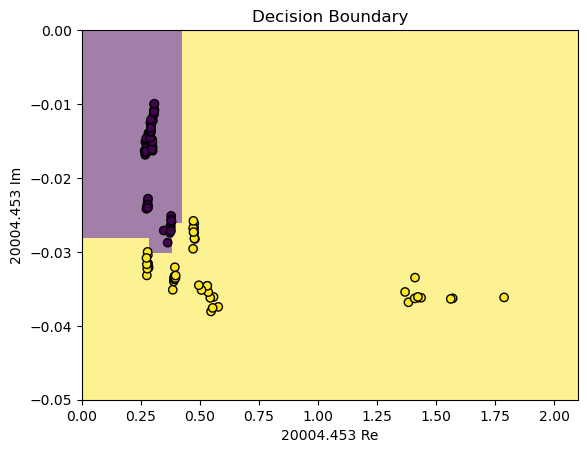

In [24]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=3, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5,plot_method='pcolormesh',grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[60 10]
 [ 0 50]]


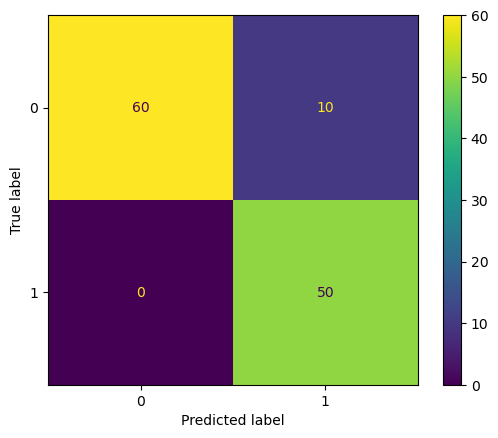

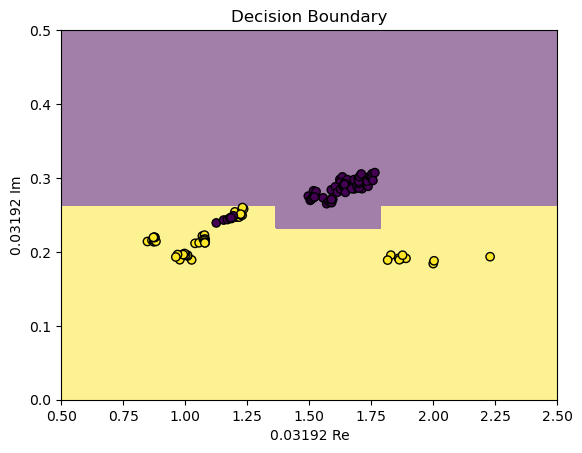

In [35]:
my_feats=['0.03192 Re','0.03192 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=2, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']
test_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01','25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=1000)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0.5,2.5)
plt.ylim(0.0,0.5)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[36  4]
 [ 4 16]]


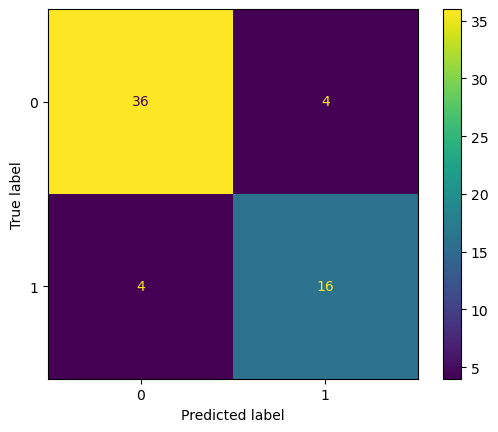

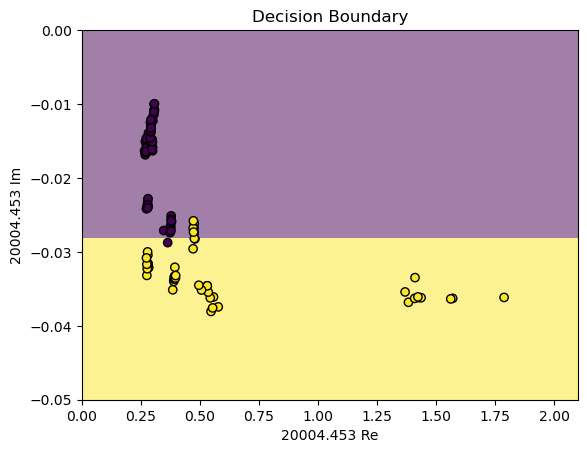

In [26]:
my_feats=['20004.453 Re','20004.453 Im']

#model=SVC(kernel="linear", C=100000, random_state=42)
model=RandomForestClassifier(max_depth=5, n_estimators=20, max_features=1)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
plt.viridis()
plt.xlim(0,2.1)
plt.ylim(-.05,0.0)
#plt.xlim(0,2.1)
#plt.ylim(0.0,0.1)
plt.show()


[[30 10]
 [ 0 20]]


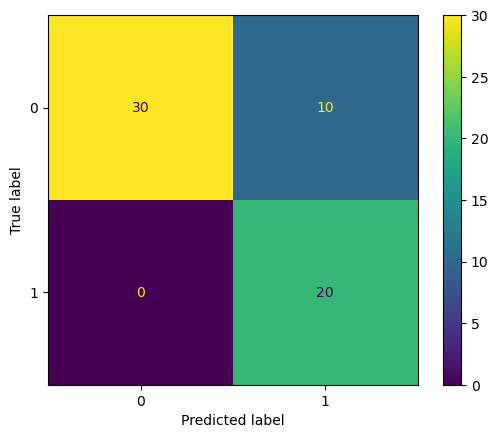

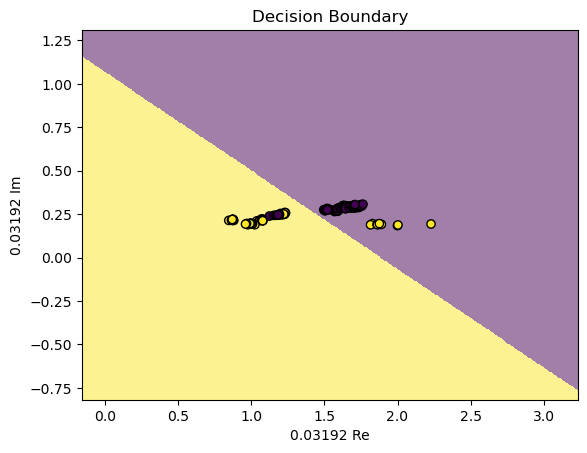

[[-3.38235 -5.9637 ]]


In [31]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['0.03192 Re','0.03192 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[30 10]
 [ 0 20]]


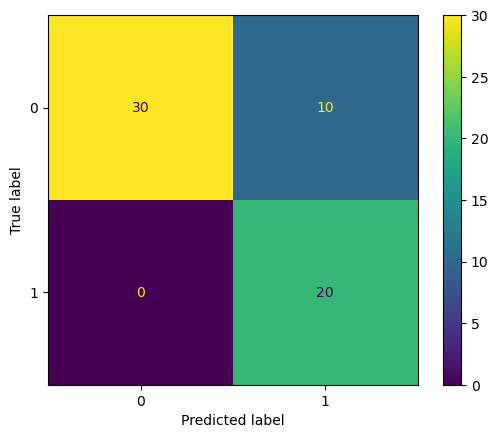

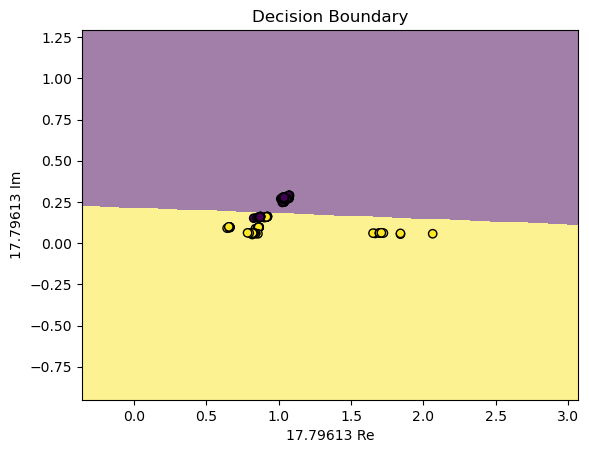

[[ -0.3500936 -10.5162886]]


In [30]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['17.79613 Re','17.79613 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

X = df_20[my_feats]
Xx_Mesh=np.linspace(min(X[my_feats[0]]),max(X[my_feats[0]]),200)
Xy_Mesh=np.linspace(min(X[my_feats[1]]),max(X[my_feats[1]]),200)
X_Total=pd.DataFrame({my_feats[0]: Xx_Mesh, my_feats[1]: Xy_Mesh}, columns=[my_feats[0], my_feats[1]])
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X_Total, response_method="predict",plot_method='pcolormesh',alpha=0.5,grid_resolution=500)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.title('Decision Boundary')
#plt.xlim(0,2.1)
#plt.ylim(-.05,0.0)
plt.show()
print(tmdl.coef_)

[[30 10]
 [ 0 20]]


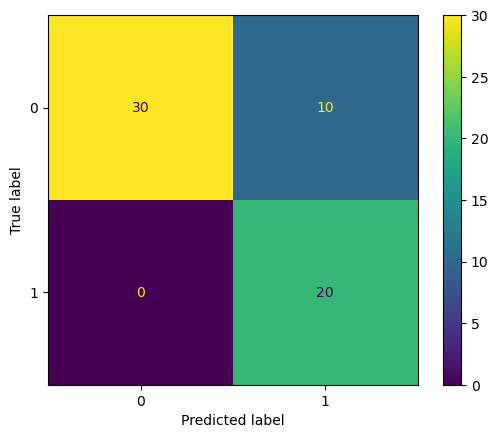

In [211]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['2.16054 Re','2.16054 Im']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

[[30 10]
 [ 0 20]]


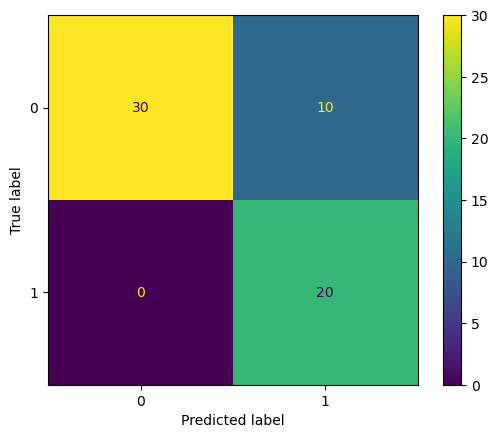

In [212]:
#my_feats=['20004.453 Re','20004.453 Im','8.81772 Re','8.81772 Im']
my_feats=['EIS_PCA_1','EIS_PCA_2']

model=SVC(kernel="linear", C=5, random_state=121)

train_Lst = ['25C01','25C02','25C03','25C04','35C01','45C01']
test_Lst = ['25C05','25C06','25C07','25C08','35C02','45C02']

tc,pc,tmdl=run_Classification_ML(df_20,train_Lst,test_Lst,my_feats,model)

cm=confusion_matrix(tc,pc)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot()
plt.show()

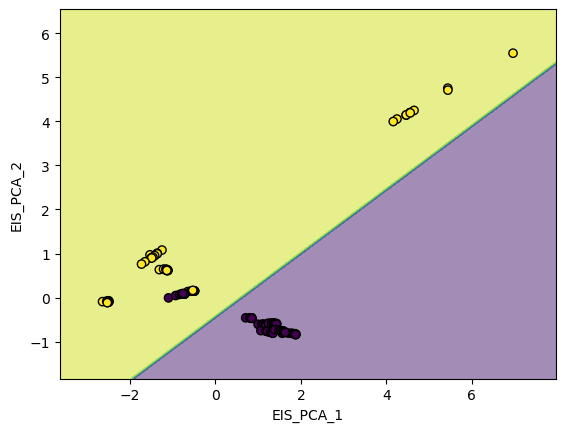

In [216]:
X = df_20[my_feats]
targets = df_20['category']
disp = DecisionBoundaryDisplay.from_estimator(tmdl, X, response_method="predict",alpha=0.5)
disp.ax_.scatter(X[my_feats[0]], X[my_feats[1]], c=targets, edgecolor="k")
plt.show()

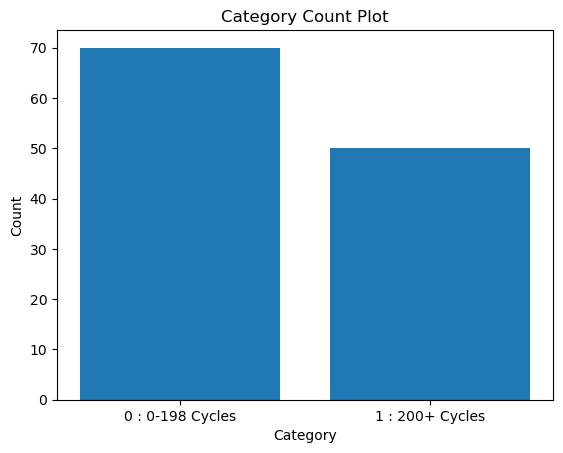

In [40]:
#For classification, category should be relatively balanced. 
#We balance the data by taking only the first 20 cycles for every battery. 
counts=df_20['category'].value_counts()
plt.bar(['0 : 0-198 Cycles','1 : 200+ Cycles'],[counts[0],counts[1]])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Count Plot')
plt.show()

In [41]:
#Function to display a plot quickly.
def plot_CF(mydf,col1,col2):
    plt.scatter(mydf[col1],mydf[col2],c=mydf['category'])
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(col1+' vs. '+col2)
    plt.show()